In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns
from scipy.stats import ttest_rel, wilcoxon

In [2]:
df = pd.read_csv('../survey_experiment/results-survey929121.csv')

In [3]:
display(df.head())

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,block,M01,M02,...,K02Time,K03Time,groupTime27791,G00Q02Time,G00Q03Time,G00Q04Time,groupTime29372,sexTime,ageTime,educTime
0,1,2025-07-05 14:43:13,6,de,352066507,2025-07-05 14:40:44,2025-07-05 14:43:13,1,NaN,NaN,...,NaN,NaN,10.76,NaN,NaN,NaN,10.16,NaN,NaN,NaN
1,2,2025-07-05 16:04:16,6,de,1428878115,2025-07-05 16:00:57,2025-07-05 16:04:16,1,NaN,NaN,...,NaN,NaN,18.21,NaN,NaN,NaN,19.19,NaN,NaN,NaN
2,3,NaN,2,de,1661822640,2025-07-05 19:01:52,2025-07-05 19:01:59,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2025-07-05 19:07:06,6,de,1661822640,2025-07-05 19:01:55,2025-07-05 19:07:06,1,NaN,NaN,...,NaN,NaN,51.40,NaN,NaN,NaN,16.15,NaN,NaN,NaN
4,5,2025-07-05 19:43:57,6,de,619222703,2025-07-05 19:41:42,2025-07-05 19:43:57,0,Wilde Müllkippe 🧹,Straßen 🚧,...,NaN,NaN,13.93,NaN,NaN,NaN,11.77,NaN,NaN,NaN


In [6]:
print(list(df.columns))

['id', 'submitdate', 'lastpage', 'startlanguage', 'seed', 'startdate', 'datestamp', 'block', 'M01', 'M02', 'M03', 'M04', 'M05', 'M06', 'M07', 'M08', 'P01', 'P01V', 'P01M', 'P01N', 'P01S', 'P02', 'P02V', 'P02M', 'P02N', 'P02S', 'P03', 'P03V', 'P03M', 'P03N', 'P03S', 'P04', 'P04V', 'P04M', 'P04N', 'P04S', 'P05', 'P05V', 'P05M', 'P05N', 'P05S', 'P06', 'P06V', 'P06M', 'P06N', 'P06S', 'P07', 'P07V', 'P07M', 'P07N', 'P07S', 'P08', 'P08V', 'P08M', 'P08N', 'P08S', 'K01', 'K02', 'K03', 'G00Q02[SQ001]', 'G00Q02[SQ002]', 'G00Q02[SQ003]', 'G00Q03[SQ001]', 'G00Q03[SQ002]', 'G00Q03[SQ003]', 'G00Q04[SQ001]', 'G00Q04[SQ002]', 'G00Q04[SQ003]', 'sex', 'age', 'educ', 'interviewtime', 'groupTime27792', 'blockTime', 'groupTime27793', 'M01Time', 'M02Time', 'M03Time', 'M04Time', 'M05Time', 'M06Time', 'M07Time', 'M08Time', 'groupTime27847', 'P01Time', 'P01VTime', 'P01MTime', 'P01NTime', 'P01STime', 'P02Time', 'P02VTime', 'P02MTime', 'P02NTime', 'P02STime', 'P03Time', 'P03VTime', 'P03MTime', 'P03NTime', 'P03ST

# Subjective ease of categorization

For this, K01 measures categorization confidence (the outcome of interest). We also have K02, which assesses whether there were difficulties, and K03 as an open text option.

## Categorization confidence

### Descriptive statistics

In [17]:
cat_confidence = ['Sehr sicher', 'Sicher', 'Weder sicher noch unsicher', 'Unsicher', 'Sehr unsicher']
df['K01'] = pd.Categorical(df['K01'], categories=cat_confidence, ordered=True)
print(df['K01'].value_counts().sort_index())
print(df.groupby('block')['K01'].value_counts(normalize=True).sort_index())

K01
Sehr sicher                    4
Sicher                        34
Weder sicher noch unsicher     8
Unsicher                       5
Sehr unsicher                  1
Name: count, dtype: int64
block  K01                       
0      Sehr sicher                   0.071429
       Sicher                        0.535714
       Weder sicher noch unsicher    0.214286
       Unsicher                      0.142857
       Sehr unsicher                 0.035714
1      Sehr sicher                   0.083333
       Sicher                        0.791667
       Weder sicher noch unsicher    0.083333
       Unsicher                      0.041667
       Sehr unsicher                 0.000000
Name: proportion, dtype: float64


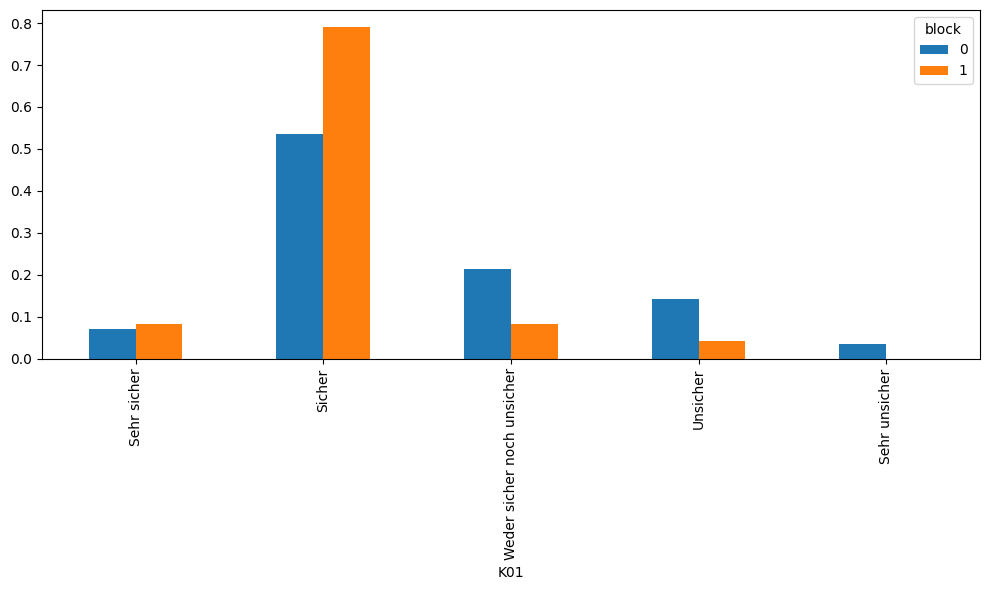

In [20]:
perc = df.groupby('block')['K01'].value_counts(normalize=True).sort_index().unstack(level=0).fillna(0)

ax = perc.plot(kind='bar', figsize=(10,6))
plt.tight_layout()
plt.show()

## Regression

We will begin with a simple OLS, just using block as predictor and then continuously add other predictors.

In [68]:
mapping = {
    'Sehr sicher': 5,
    'Sicher': 4,
    'Weder sicher noch unsicher': 3,
    'Unsicher': 2,
    'Sehr unsicher': 1
}
df['K01_num'] = df['K01'].map(mapping)
df_model = df.dropna(subset=['K01_num', 'block'])
df_model['K01_num'] = pd.to_numeric(df_model['K01_num'])
model = smf.ols('K01_num ~ block', data=df_model).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                K01_num   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     4.032
Date:                Tue, 08 Jul 2025   Prob (F-statistic):             0.0501
Time:                        21:01:25   Log-Likelihood:                -61.802
No. Observations:                  52   AIC:                             127.6
Df Residuals:                      50   BIC:                             131.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4643      0.153     22.634      0.0

/tmp/ipykernel_1765/3752901577.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['K01_num'] = pd.to_numeric(df_model['K01_num'])


/tmp/ipykernel_1765/4259746265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['fitted'] = pred_table['mean']
/tmp/ipykernel_1765/4259746265.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['mean_ci_lower'] = pred_table['mean_ci_lower']
/tmp/ipykernel_1765/4259746265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

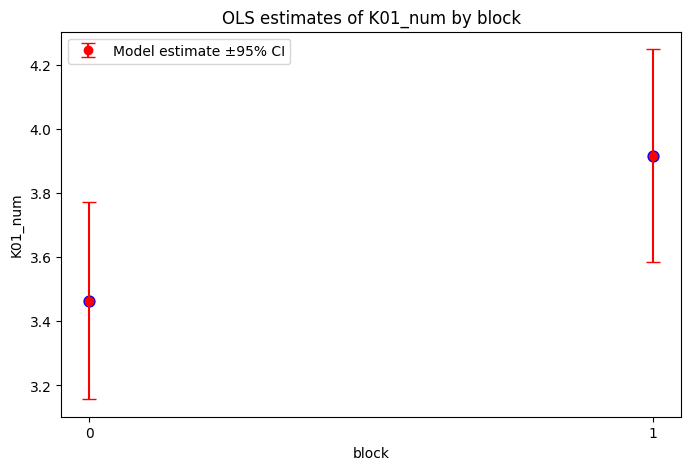

In [69]:
pred_table = model.get_prediction().summary_frame(alpha=0.05)
df_model['fitted'] = pred_table['mean']
df_model['mean_ci_lower'] = pred_table['mean_ci_lower']
df_model['mean_ci_upper'] = pred_table['mean_ci_upper']

# Plot point estimates with CI
plt.figure(figsize=(8,5))
sns.pointplot(x='block', y='K01_num', data=df_model, 
              ci=None, color='blue', join=False)

# Overlay predicted means from model
mean_preds = df_model.groupby('block')[['fitted', 'mean_ci_lower', 'mean_ci_upper']].mean().reset_index()

plt.errorbar(mean_preds['block'], mean_preds['fitted'],
             yerr=[mean_preds['fitted'] - mean_preds['mean_ci_lower'],
                   mean_preds['mean_ci_upper'] - mean_preds['fitted']],
             fmt='o', color='red', capsize=5, label='Model estimate ±95% CI')

plt.ylabel('K01_num')
plt.title('OLS estimates of K01_num by block')
plt.legend()
plt.show()

Predictors:
- Bekanntheit Mangelmelder
- Sozio-demographisch

In [53]:

df['MM_bekannt'] = df['G00Q02[SQ002]'].apply(lambda x: 1 if x == 'Nein' else 0)
df['MM_OL_bekannt'] = df['G00Q03[SQ001]'].apply(lambda x: 1 if x == 'Ja' else 0)
df['MM_OL_benutzt'] = df['G00Q04[SQ001]'].apply(lambda x: 1 if x == 'Ja' else 0)


In [49]:
df['educ'].value_counts()
# transform into with/without university degree
df['educ_bin'] = df['educ'].apply(lambda x: 1 if x == 'Hochschulabschluss' else 0)

In [ ]:
df['sex'].value_counts()
# done because of small sample size, which makes Divers a bad reference category (no discrimination intended)
def binarize_sex(x):
    if x == 'Männlich':
        return 1
    elif x == 'Weiblich':
        return 0
    elif x == 'Divers':
        return np.nan
df['sex_bin'] = df['sex'].apply(binarize_sex)

In [47]:
df['age'].value_counts()

age
26.0    8
21.0    8
25.0    5
29.0    4
20.0    4
33.0    3
19.0    3
28.0    3
22.0    3
24.0    3
23.0    3
27.0    2
31.0    1
30.0    1
Name: count, dtype: int64

In [58]:
df_model = df.dropna(subset=['K01_num', 'block', 'MM_bekannt', 'educ_bin', 'sex', 'age'])
df_model['K01_num'] = pd.to_numeric(df_model['K01_num'])
formula = 'K01_num ~ block + MM_bekannt + educ_bin + sex_bin + age'
model = smf.ols(formula, data=df_model).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                K01_num   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.314
Date:                Tue, 08 Jul 2025   Prob (F-statistic):              0.276
Time:                        20:49:33   Log-Likelihood:                -51.938
No. Observations:                  49   AIC:                             115.9
Df Residuals:                      43   BIC:                             127.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6561      0.930      3.929      0.0

/tmp/ipykernel_1765/3410908382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['K01_num'] = pd.to_numeric(df_model['K01_num'])


Check whether linear model is sufficient (or whether we need to switch to e.g., ordered logit). Expectation: residulas will not be normally distributed.

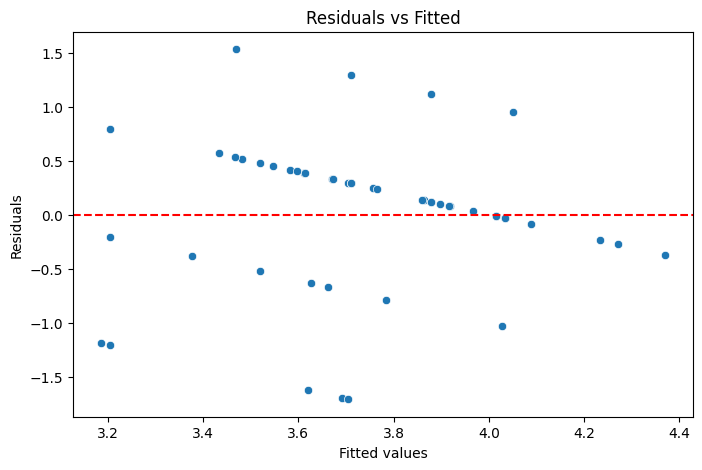

In [60]:
fitted_vals = model.fittedvalues
residuals = model.resid
plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

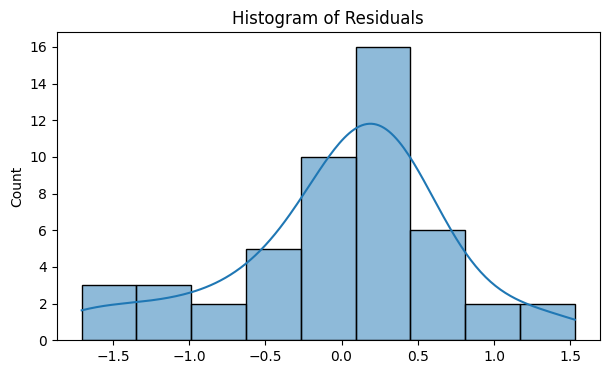

In [61]:
plt.figure(figsize=(7,4))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

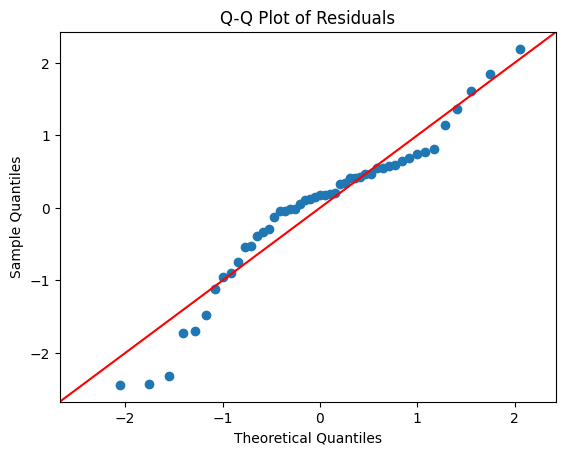

In [63]:
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

Residuals are not exactly normally distributed, but better than expected.

In [65]:
bp_test = het_breuschpagan(residuals, model.model.exog)
labels = ['Lagrange multiplier stat', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

{'Lagrange multiplier stat': np.float64(7.755007035779409), 'p-value': np.float64(0.17026457227560318), 'f-value': np.float64(1.6169977423819213), 'f p-value': np.float64(0.17600618965415982)}


Errors are homoskedastic -> good.

In [67]:
X = model.model.exog
vif_data = pd.DataFrame()
vif_data["feature"] = model.model.exog_names
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif_data)

      feature        VIF
0   Intercept  76.325504
1       block   1.015548
2  MM_bekannt   1.103255
3    educ_bin   1.769575
4     sex_bin   1.140774
5         age   1.903130


No multicollinearity -> good.

No need to check for extreme values or outliers. There will be none, given the bounded scales we are using (at least no univariate outliers).

# Objective ease of categorization

In [72]:
pd.set_option('display.max_rows', None)
display(df.head(1))

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,block,M01,M02,M03,M04,M05,M06,M07,M08,P01,P01V,P01M,P01N,P01S,P02,P02V,P02M,P02N,P02S,P03,P03V,P03M,P03N,P03S,P04,P04V,P04M,P04N,P04S,P05,P05V,P05M,P05N,P05S,P06,P06V,P06M,P06N,P06S,P07,P07V,P07M,P07N,P07S,P08,P08V,P08M,P08N,P08S,K01,K02,K03,G00Q02[SQ001],G00Q02[SQ002],G00Q02[SQ003],G00Q03[SQ001],G00Q03[SQ002],G00Q03[SQ003],G00Q04[SQ001],G00Q04[SQ002],G00Q04[SQ003],sex,age,educ,interviewtime,groupTime27792,blockTime,groupTime27793,M01Time,M02Time,M03Time,M04Time,M05Time,M06Time,M07Time,M08Time,groupTime27847,P01Time,P01VTime,P01MTime,P01NTime,P01STime,P02Time,P02VTime,P02MTime,P02NTime,P02STime,P03Time,P03VTime,P03MTime,P03NTime,P03STime,P04Time,P04VTime,P04MTime,P04NTime,P04STime,P05Time,P05VTime,P05MTime,P05NTime,P05STime,P06Time,P06VTime,P06MTime,P06NTime,P06STime,P07Time,P07VTime,P07MTime,P07NTime,P07STime,P08Time,P08VTime,P08MTime,P08NTime,P08STime,groupTime29373,K01Time,K02Time,K03Time,groupTime27791,G00Q02Time,G00Q03Time,G00Q04Time,groupTime29372,sexTime,ageTime,educTime,K01_num,MM_bekannt,MM_OL_bekannt,MM_OL_benutzt,educ_bin,sex_bin
0,1,2025-07-05 14:43:13,6,de,352066507,2025-07-05 14:40:44,2025-07-05 14:43:13,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Müllentsorgung,NaN,Umweltverschmutzung,NaN,NaN,Verkehr & Infrastruktur,Asphalt & Schlaglöcher,NaN,NaN,NaN,Müllentsorgung,NaN,Sperrmüll,NaN,NaN,Müllentsorgung,NaN,Altglas- & Altkleidercontainer,NaN,NaN,Müllentsorgung,NaN,Öffentliche Mülleimer,NaN,NaN,Verkehr & Infrastruktur,"Ampeln, Verkehrsschilder & Straßenbeleuchtung",NaN,NaN,NaN,Müllentsorgung,NaN,Gefahrenstoffe,NaN,NaN,Müllentsorgung,NaN,Sperrmüll,NaN,NaN,Sicher,Ja,Müll am Straßenrand etwas anderes als Sperrmüll,Ja,Nein,Nein,Ja,Nein,Nein,Nein,Ja,Nein,Männlich,29.0,Hochschulabschluss,144.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.89,NaN,NaN,NaN,10.76,NaN,NaN,NaN,10.16,NaN,NaN,NaN,4,1,1,0,1,1.0


# Go through each picture and see categories chosen

In [75]:
for i in range(1,8):
    print(f'Old categories: {df[f'M0{i}'].value_counts()}')
    print(f'New categories: {df[f'P0{i}'].value_counts()}')

Old categories: M01
Wilde Müllkippe 🧹    22
Abfall 🗑              7
Name: count, dtype: int64
New categories: P01
Müllentsorgung                18
Natur & öffentliche Plätze     5
Name: count, dtype: int64
Old categories: M02
Straßen 🚧    29
Name: count, dtype: int64
New categories: P02
Verkehr & Infrastruktur    23
Name: count, dtype: int64
Old categories: M03
Abfall 🗑             15
Wilde Müllkippe 🧹    13
Straßen 🚧             1
Name: count, dtype: int64
New categories: P03
Müllentsorgung                21
Natur & öffentliche Plätze     2
Name: count, dtype: int64
Old categories: M04
Wilde Müllkippe 🧹    18
Abfall 🗑             11
Name: count, dtype: int64
New categories: P04
Müllentsorgung                22
Natur & öffentliche Plätze     1
Name: count, dtype: int64
Old categories: M05
Abfall 🗑             21
Wilde Müllkippe 🧹     8
Name: count, dtype: int64
New categories: P05
Müllentsorgung                22
Natur & öffentliche Plätze     1
Name: count, dtype: int64
Old categories

In [76]:
# look at sub-categories
sub_cats = ['V', 'M', 'N', 'S']
for i in range(1,8):
    print(f'New categories: {df[f'P0{i}'].value_counts()}')
    for j in sub_cats:
        print(df[f'P0{i}{j}'].value_counts())

New categories: P01
Müllentsorgung                18
Natur & öffentliche Plätze     5
Name: count, dtype: int64
Series([], Name: count, dtype: int64)
P01M
Umweltverschmutzung    18
Name: count, dtype: int64
P01N
Umweltverschmutzung    4
Sonstiges              1
Name: count, dtype: int64
Series([], Name: count, dtype: int64)
New categories: P02
Verkehr & Infrastruktur    23
Name: count, dtype: int64
P02V
Asphalt & Schlaglöcher    19
Fahrradwege                3
Sonstiges                  1
Name: count, dtype: int64
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
New categories: P03
Müllentsorgung                21
Natur & öffentliche Plätze     2
Name: count, dtype: int64
Series([], Name: count, dtype: int64)
P03M
Sperrmüll              19
Umweltverschmutzung     1
Sonstiges               1
Name: count, dtype: int64
P03N
Umweltverschmutzung    2
Name: count, dtype: int64
Series([], Name: count, dtype: int64)
New categorie

In [88]:
# extract level of agreement (based on top category)
agreement = []
for i in range(1,9):
    old_cat_agreement = df[f'M0{i}'].value_counts(normalize=True).iloc[0]
    new_cat_agreement = df[f'P0{i}'].value_counts(normalize=True).iloc[0]
    agreement.append({'old': old_cat_agreement,
                             'new': new_cat_agreement})
agreement_df = pd.DataFrame(agreement)
display(agreement_df)
    

,old,new
0,0.758621,0.782609
1,1.000000,1.000000
2,0.517241,0.913043
3,0.620690,0.956522
4,0.724138,0.956522
5,0.862069,0.869565
6,0.620690,0.826087
7,0.758621,0.913043


In [89]:
# do some significance testing for each picture
#t-test
t_stat, p_value = ttest_rel(agreement_df['new'], agreement_df['old'])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_value:.3f}")
#Wilcoxon signed rank
w_stat, p_value = wilcoxon(agreement_df['new'], agreement_df['old'])
print(f"Wilcoxon signed-rank test: W = {w_stat:.3f}, p = {p_value:.3f}")

Paired t-test: t = 3.165, p = 0.016
Wilcoxon signed-rank test: W = 0.000, p = 0.016


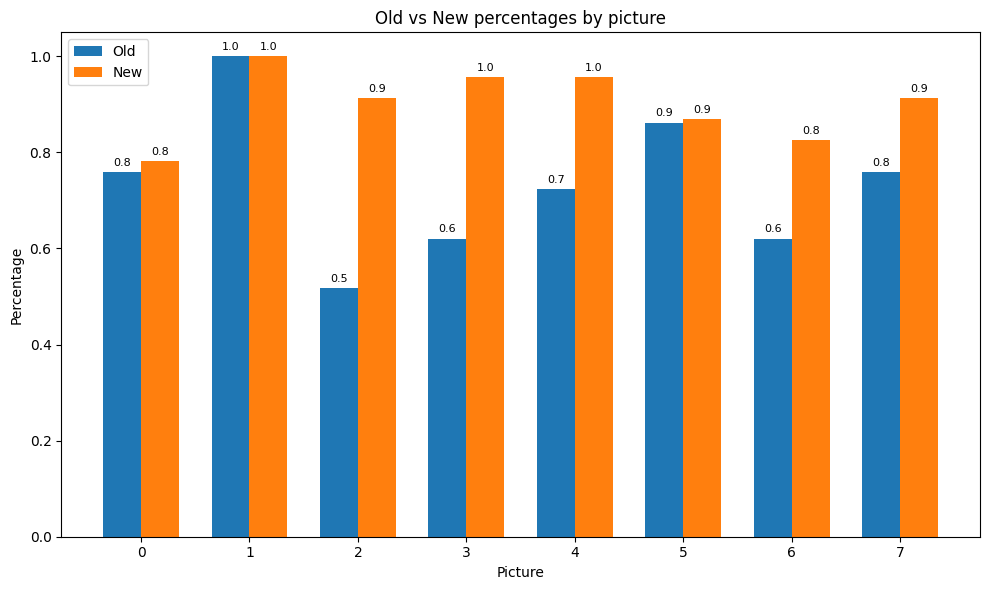

In [90]:
# Setup
x = np.arange(len(agreement_df))  # the label locations
width = 0.35            # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))

bars1 = ax.bar(x - width/2, agreement_df['old'], width, label='Old')
bars2 = ax.bar(x + width/2, agreement_df['new'], width, label='New')

# Labels etc.
ax.set_ylabel('Percentage')
ax.set_xlabel('Picture')
ax.set_title('Old vs New percentages by picture')
ax.set_xticks(x)
#ax.set_xticklabels(df['picture'], rotation=45, ha='right')
ax.legend()

# Optionally add value labels on top
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0,3),  # offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()